In [1]:
# Imports

# Numpy,Pandas
import numpy as np
import pandas as pd

# matplotlib,seaborn,missingno

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline
import missingno as msno

# ignore warnings
import warnings
warnings.filterwarnings('ignore')  
 

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
loans = pd.read_csv('loans_preprocessed.csv')
loans.head()


,loan_amnt,term,int_rate,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,debt_settlement_flag_N,debt_settlement_flag_Y
0,2500.00000,60,15.27000,59.83000,3,0,30000.00000,0,1.00000,0.00000,...,0,0,0,0,0,0,0,0,1,0
1,10000.00000,36,13.49000,339.31000,3,10,49200.00000,1,20.00000,0.00000,...,0,0,0,1,0,0,0,0,1,0
2,3000.00000,60,12.69000,67.79000,2,1,80000.00000,1,17.94000,0.00000,...,0,0,0,1,0,0,0,0,1,0
3,5000.00000,36,7.90000,156.46000,1,3,36000.00000,1,11.20000,0.00000,...,0,0,0,0,0,0,0,1,1,0
4,7000.00000,60,15.96000,170.08000,3,8,47004.00000,1,23.51000,0.00000,...,0,0,0,0,0,0,0,0,1,0


In [3]:
col = loans.select_dtypes(include=['int64','float64']).columns
col = col.drop('loan_status') 
 
loans_ml = loans


In [4]:
from sklearn import preprocessing

sc = preprocessing.StandardScaler()  
loans_ml[col] =sc.fit_transform(loans_ml[col])  #peature scaling

In [5]:
# seperate data to x and y
x_feature = list(loans_ml.columns)
x_feature.remove('loan_status')
x_val = loans_ml[x_feature]
y_val = loans_ml['loan_status']
len(x_feature)

39

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# logistic regression classifier
model = LogisticRegression()

# feature select using RFE, 15 features
rfe = RFE(model, 15) 
rfe = rfe.fit(x_val, y_val)

print(rfe.n_features_)
print(rfe.estimator_ )
print(rfe.support_)
print(rfe.ranking_) #ranking = 1 means feature is selected

15
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[ True  True  True  True  True False  True False False  True False  True
  True  True False False False False False False False False False False
  True False False False False False False False  True False  True False
 False  True  True]
[ 1  1  1  1  1  4  1 22 25  1  8  1  1  1 15 12 18  7 19  5 16 24 23 13
  1 21  6 20 17  3  9 10  1 14  1 11  2  1  1]


In [7]:
col_filter = x_val.columns[rfe.support_] 
col_filter

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'annual_inc',
       'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util',
       'purpose_credit_card', 'purpose_other', 'purpose_small_business',
       'debt_settlement_flag_N', 'debt_settlement_flag_Y'],
      dtype='object')

In [8]:
from sklearn.ensemble import RandomForestClassifier
names = loans_ml[col_filter].columns
clf=RandomForestClassifier(n_estimators=15,random_state=0) # Feature importances by RandomForestClassifier
clf.fit(x_val[col_filter], y_val) 
for feature in zip(names, clf.feature_importances_):
    print(feature)

('loan_amnt', 0.1074460899059568)
('term', 0.01776759340967394)
('int_rate', 0.1328947729616178)
('installment', 0.14478839099534038)
('grade', 0.031656731154083434)
('annual_inc', 0.153208552040927)
('inq_last_6mths', 0.041415303537289214)
('pub_rec', 0.009611507534272137)
('revol_bal', 0.15729957598214112)
('revol_util', 0.15605525351554567)
('purpose_credit_card', 0.008636066130164247)
('purpose_other', 0.009807958218624959)
('purpose_small_business', 0.008421981705247559)
('debt_settlement_flag_N', 0.013243883745818552)
('debt_settlement_flag_Y', 0.007746339163297222)


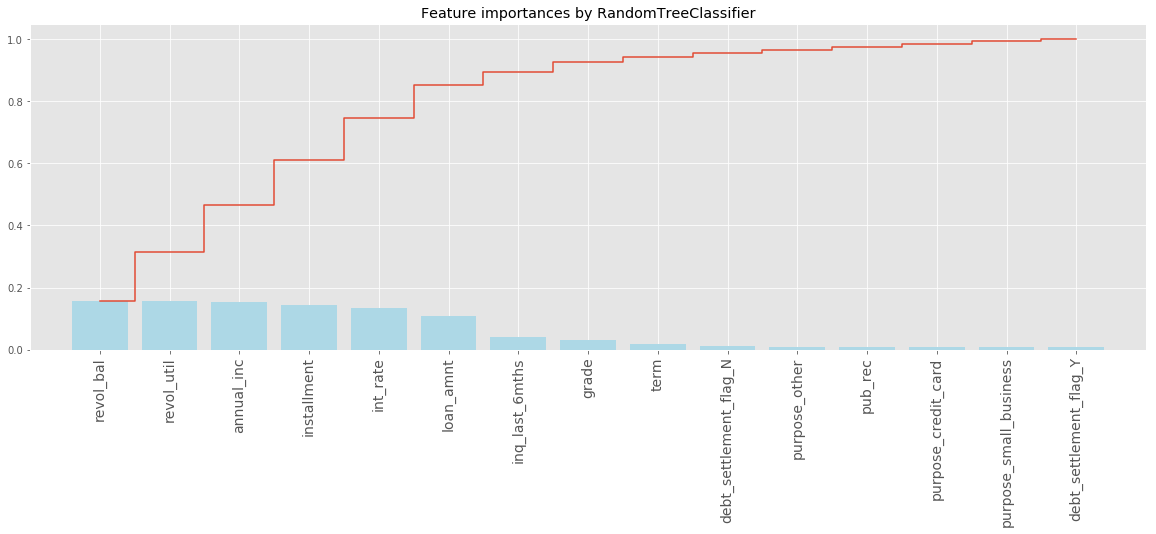

In [9]:
plt.style.use('ggplot')
 
## feature importances visualization##
importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()
 

In [10]:
# check the samples
X = loans_ml[col_filter]
y = loans_ml["loan_status"]
 
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('Total samples：{}; Positive samples: {:.2%}; Negative samples: {:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('Features：', X.shape[1])

Total samples：36492; Positive samples: 13.66%; Negative samples: 86.34%
Features： 15


In [11]:
# deal with imbalanced samples
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)    # use SMOTE method
X, y = sm.fit_sample(X, y)
print('After SMOTE method')
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('Total samples：{}; Positive samples: {:.2%}; Negative samples: {:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))


After SMOTE method
Total samples：63018; Positive samples: 50.00%; Negative samples: 50.00%


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 

param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=5) 
grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(grid_search.best_score_))

Best parameters: {'C': 0.1, 'penalty': 'l1'}
Best cross-validation score: 0.64626


In [14]:
print("Best estimator:\n{}".format(grid_search.best_estimator_)) 

Best estimator:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [15]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_test, y_pred,)))

Test set accuracy score: 0.65090


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      9491
           1       0.65      0.66      0.65      9415

   micro avg       0.65      0.65      0.65     18906
   macro avg       0.65      0.65      0.65     18906
weighted avg       0.65      0.65      0.65     18906



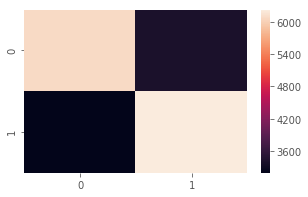

In [17]:
from sklearn.metrics import confusion_matrix
m2 = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(5,3))
sns.heatmap(m2) # confusion matrix

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc2 = roc_auc_score(y_test, y_pred)
print("Area under the ROC curve : %f" % roc_auc2)

Area under the ROC curve : 0.650944
